kornia sadece "torch.tensor" tipini kabul ettiğinden
veri tipinin yazılmasını tavsiye ediyor.

In [11]:
import torch
import kornia
import cv2
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# read the image with OpenCV
img: np.ndarray = cv2.imread('../KendiResmim.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # normalleştirme
img = img + np.random.normal(loc=0.0, scale=0.2, size=img.shape)  # gürültü eklendi
img = np.clip(img, 0.0, 1.0)  # olması gerekenden
# daha büyük veya küçük değer olmasına karşın önlem.

convert to torch tensor

In [12]:
noisy_image: torch.tensor = kornia.image_to_tensor(img).squeeze()  # CxHxW


Veri setini tanımla

In [13]:
# total variation denoising network
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super(TVDenoise, self).__init__()
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.regularization_term = kornia.losses.TotalVariation()
        # gürültüsünü azaltacağımız resim parametre olarak geldi.
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l2_term(self.clean_image, self.noisy_image) + \
               0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image

noisy_image = noisy_image.to(device)
tv_denoiser = TVDenoise(noisy_image).to(device)

optimizer tanımla

In [14]:
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

num_iter = 300

for i in range(num_iter):
    optimizer.zero_grad()
    loss = tv_denoiser()
    if i % 25 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iter, loss.item()))
    loss.backward()
    optimizer.step()

# numpy dizisine geri dön.
img_clean: np.ndarray = kornia.tensor_to_image(tv_denoiser.get_clean_image())

Loss in iteration 0 of 300: 149.329
Loss in iteration 25 of 300: 144.179
Loss in iteration 50 of 300: 136.856
Loss in iteration 75 of 300: 129.646
Loss in iteration 100 of 300: 122.706
Loss in iteration 125 of 300: 116.044
Loss in iteration 150 of 300: 109.654
Loss in iteration 175 of 300: 103.531
Loss in iteration 200 of 300: 97.669
Loss in iteration 225 of 300: 92.061
Loss in iteration 250 of 300: 86.704
Loss in iteration 275 of 300: 81.593


plot

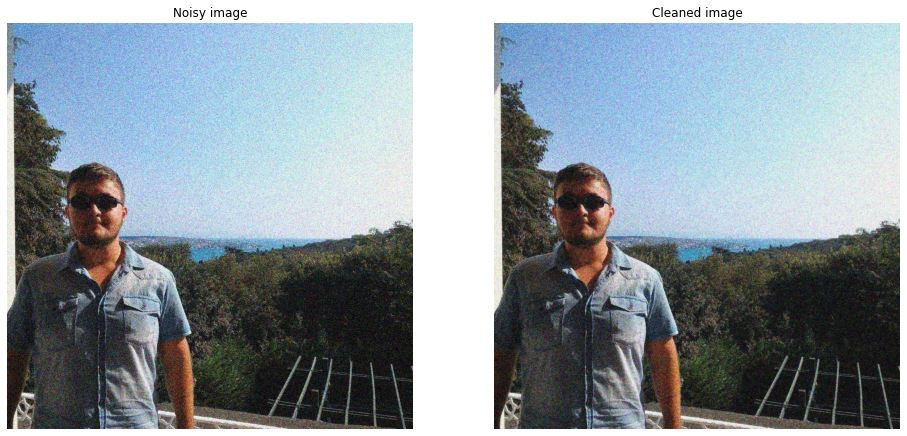

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Noisy image')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('Cleaned image')
axs[1].imshow(img_clean)

plt.show()